## Import libraries

In [68]:
%load_ext autoreload
%autoreload 2
from linien_server.autolock.robust import calculate_autolock_instructions,get_lock_position_from_autolock_instructions
from linien_server.autolock.utils import crop_spectra_to_same_view,sum_up_spectrum,get_diff_at_time_scale,get_time_scale,get_all_peaks,get_lock_region,get_target_peak
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import spectra from RP via ssh

The RP saves a set of spectra used to run the threshold analysis in order to obtain the parameters to program the fast FPGA locking algorithm. We want to get these files in order to find what's wrong with ours...

In [78]:
import subprocess

# Replace with your values
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/robust_spectra.npy"
local_path = "/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files" #MODIFICATO
key_path = "~/.ssh/rp_TN" #MODIFICATO

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

# Replace with your values
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/target_idxs.npy"
local_path = "/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files" #MODIFICATO
key_path = "~/.ssh/rp_TN" #MODIFICATO

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

CompletedProcess(args=['scp', '-i', '~/.ssh/rp_TN', 'root@192.168.1.159:/root/.local/share/linien/target_idxs.npy', '/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files'], returncode=0)

In [7]:
#import subprocess
#
## Replace with your values
#remote_user = "root"
#remote_ip = "10.194.33.151"
#remote_port = "2223"
#remote_path = "/root/.local/share/linien/robust_spectra.npy"
#local_path = "/home/jacklook/Documents/Projects/CodeRed" #DA MODIFICARE                            COS'è?
#key_path = "/home/jacklook/.ssh/rp_TN" #DA MODIFICARE
#
## Use scp with SSH key
#command = [
#    "scp",
#    "-i", key_path,
#    "-P", remote_port,
#    f"{remote_user}@{remote_ip}:{remote_path}",
#    local_path
#]
#
#subprocess.run(command)

CompletedProcess(args=['scp', '-i', '/home/jacklook/.ssh/rp_TN', '-P', '2223', 'root@10.194.33.151:/root/.local/share/linien/robust_spectra.npy', '/home/jacklook/Documents/Projects/CodeRed'], returncode=0)

spectra contains different spectra y-values without the corresponding x coordinate.

In [82]:
print("--- spectra properties ---")
spectra = np.load('/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files/robust_spectra.npy')
print("spectra shape: ", spectra.shape)
print("spectra : \n", spectra)
N_SPECTRA = spectra.shape[0]
print(f"Number of spectra: {N_SPECTRA}")

print("\n--- idxs properties ---")
target_idxs = np.load('/home/bec3/Desktop/Simone_Damian/Serafini/Imported_files/target_idxs.npy')
print("target_idxs shape: ", target_idxs.shape)
print("target_idxs: \n", target_idxs)

--- spectra properties ---
spectra shape:  (5, 2048)
spectra : 
 [[26  1  1 ... -3 -3 -2]
 [24  1  1 ... -3 -3 -3]
 [20  1  1 ... -2 -2 -2]
 [25  1  1 ... -3 -3 -4]
 [26  1  1 ... -4 -4 -4]]
Number of spectra: 5

--- idxs properties ---
target_idxs shape:  (2,)
target_idxs: 
 [406 428]


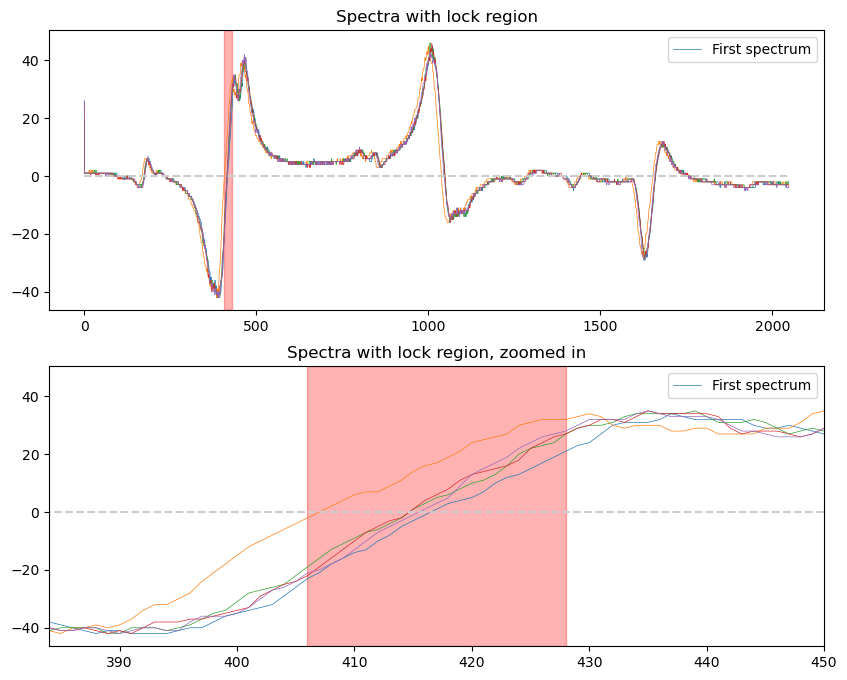

In [80]:
# Visualize the spectra and highlight the lock region

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for i in range(N_SPECTRA):
    if i == 0:
        axs[0].plot(spectra[i], lw=0.5, label = 'First spectrum')
    else:
        axs[0].plot(spectra[i], lw=0.5)

x0 = target_idxs[0]
x1 = target_idxs[1]
axs[0].hlines(0, 0, spectra.shape[1], color = '0.8', ls = '--')
axs[0].axvspan(x0, x1, color='red', alpha=0.3)
axs[0].set_title('Spectra with lock region')
axs[0].legend()

#Zoom to highlight the jitter
for i in range(N_SPECTRA):
    if i == 0:
        axs[1].plot(spectra[i], lw=0.5, label = 'First spectrum')
    else:
        axs[1].plot(spectra[i], lw=0.5)

x0 = target_idxs[0]
x1 = target_idxs[1]
window_width = x1 - x0
axs[1].hlines(0, 0, spectra.shape[1], color = '0.8', ls = '--')
axs[1].axvspan(x0, x1, color='red', alpha=0.3)
axs[1].set_title('Spectra with lock region, zoomed in')
axs[1].set_xlim(x0-window_width, x1+window_width)
axs[1].legend()


In [118]:
x0 = 300
x1 = 500

--- spectra_cropped properties ---
spectra_cropped shape: 
 (5, 2039)
spectra_cropped: 
 [[ 1  1  1 ... -3 -3 -2]
 [24  1  1 ... -3 -2 -2]
 [ 1  1  1 ... -2 -2 -2]
 [ 1  1  1 ... -3 -3 -4]
 [ 1  1  1 ... -4 -4 -4]]

--- crop_left properties ---
crop_left: 
 9


Text(0.5, 1.0, 'Spectra with lock region after cropping, zoomed in')

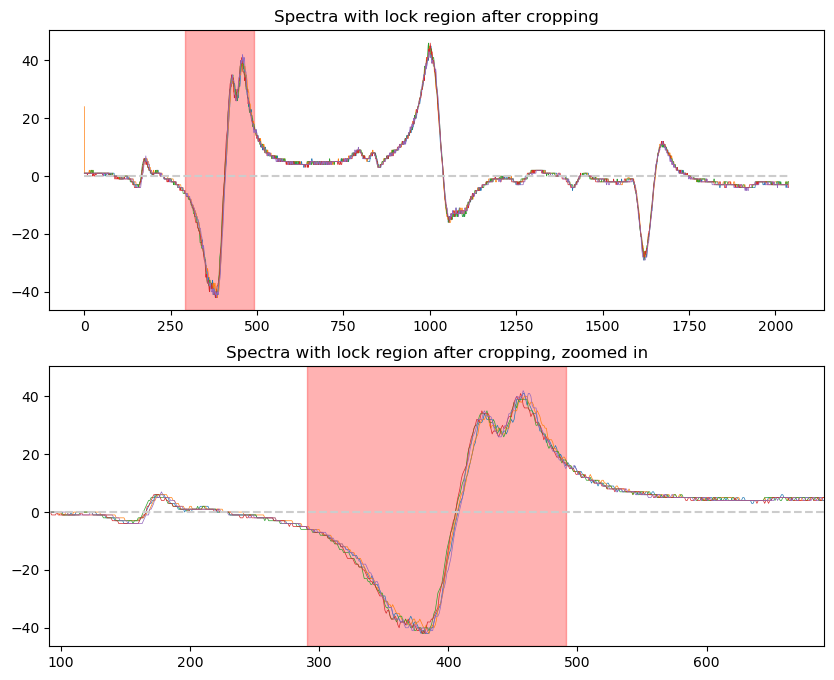

In [119]:
target_idxs = (x0,x1)

spectra_cropped, crop_left = crop_spectra_to_same_view(spectra)
spectra_cropped = np.array(spectra_cropped)

print("--- spectra_cropped properties ---")
print("spectra_cropped shape: \n", spectra_cropped.shape)
print("spectra_cropped: \n", spectra_cropped)

print("\n--- crop_left properties ---")
print("crop_left: \n", crop_left)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for i in range(N_SPECTRA):
    axs[0].plot(spectra_cropped[i], lw=0.5)

target_idxs = [idx - crop_left for idx in target_idxs]

axs[0].hlines(0, 0, spectra_cropped.shape[1], color = '0.8', ls = '--')
axs[0].axvspan(target_idxs[0], target_idxs[1], color='red', alpha=0.3)
axs[0].set_title('Spectra with lock region after cropping')

for i in range(N_SPECTRA):
    axs[1].plot(spectra_cropped[i], lw=0.5)

window_width_cropped = target_idxs[1] - target_idxs[0]
axs[1].hlines(0, 0, spectra_cropped.shape[1], color = '0.8', ls = '--')
axs[1].axvspan(target_idxs[0], target_idxs[1], color='red', alpha=0.3)
axs[1].set_xlim(target_idxs[0] - window_width_cropped, target_idxs[1] + window_width_cropped)
axs[1].set_title('Spectra with lock region after cropping, zoomed in')

If we are centered decently these two should be similar:
time_scale 76
window_width_cropped 200


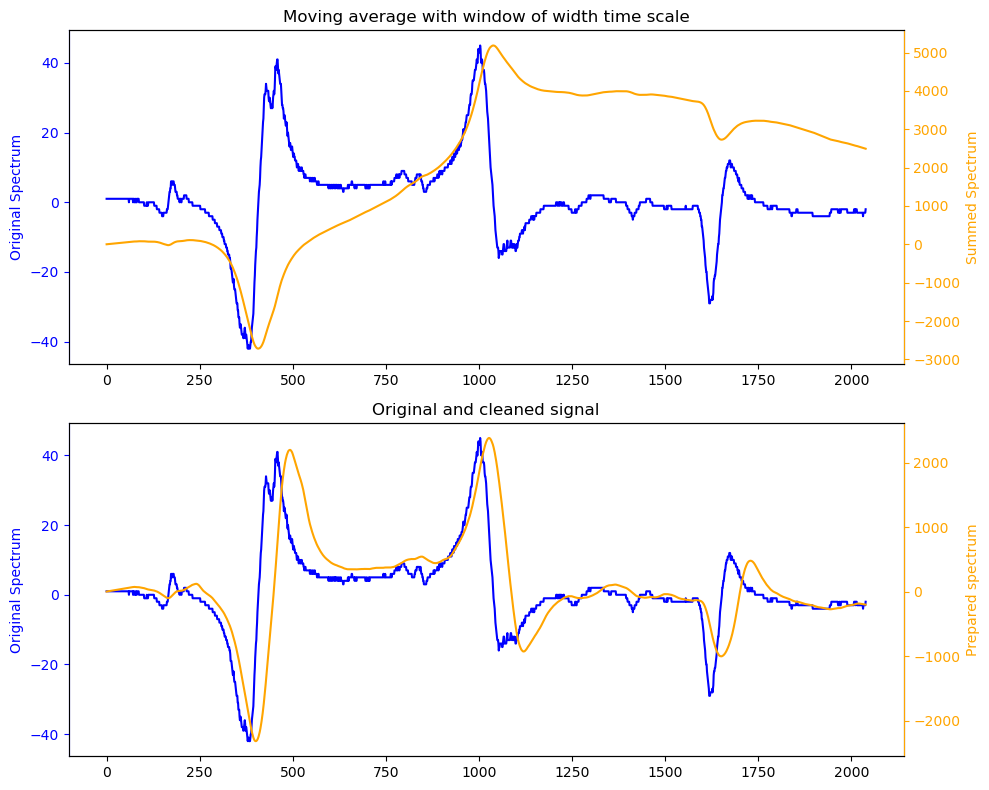

In [120]:
time_scale = int(round(np.mean([get_time_scale(spectrum, target_idxs) for spectrum in spectra]))) #not with the cropped one? They have been translated with respect to te locking window so the values coul be changed
print('If we are centered decently these two should be similar:')
print('time_scale', time_scale)
print('window_width_cropped', window_width_cropped)

prepared_spectrum = get_diff_at_time_scale(sum_up_spectrum(spectra_cropped[0]), time_scale) #to clean the signal they use a moving average and then they re-derive it

#--- original spectrum and its moving average ---

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

ax0 = axs[0] # Primary y-axis
ax1 = ax0.twinx() # Secondary y-axis

# Plot data
color0 = 'blue'
color1 = 'orange'

ax0.plot(spectra_cropped[0], label='Original spectrum', color=color0)
ax1.plot(sum_up_spectrum(spectra_cropped[0]), label='Summed spectrum', color=color1)

# Set y-axis labels with matching colors
ax0.set_ylabel("Original Spectrum", color=color0)
ax1.set_ylabel("Summed Spectrum", color=color1)

# Color tick labels to match lines
ax0.tick_params(axis='y', colors=color0)
ax1.tick_params(axis='y', colors=color1)

# Also color the axis spines (left and right)
ax0.spines['left'].set_color(color0)
ax1.spines['right'].set_color(color1)

# Set title
ax0.set_title("Moving average with window of width time scale")

# --- comparison between the original signal and the cleqned one ---

ax2 = axs[1] # Primary y-axis
ax3 = ax2.twinx() # Secondary y-axis

ax2.plot(spectra_cropped[0], label='Original spectrum', color=color0)
ax3.plot(prepared_spectrum, label='Prepared spectrum', color=color1)

# Set y-axis labels with matching colors
ax2.set_ylabel("Original Spectrum", color=color0)
ax3.set_ylabel("Prepared spectrum", color=color1)

# Color tick labels to match lines
ax2.tick_params(axis='y', colors=color0)
ax3.tick_params(axis='y', colors=color1)

# Also color the axis spines (left and right)
ax2.spines['left'].set_color(color0)
ax3.spines['right'].set_color(color1)

# Set title
ax2.set_title("Original and cleaned signal")

plt.tight_layout()
plt.show()

Due to the structure of the moving average the reconstructed signal will be translated with respect to the original one. Now we want to fix this shifting the target indexes too.

shift 36


[]

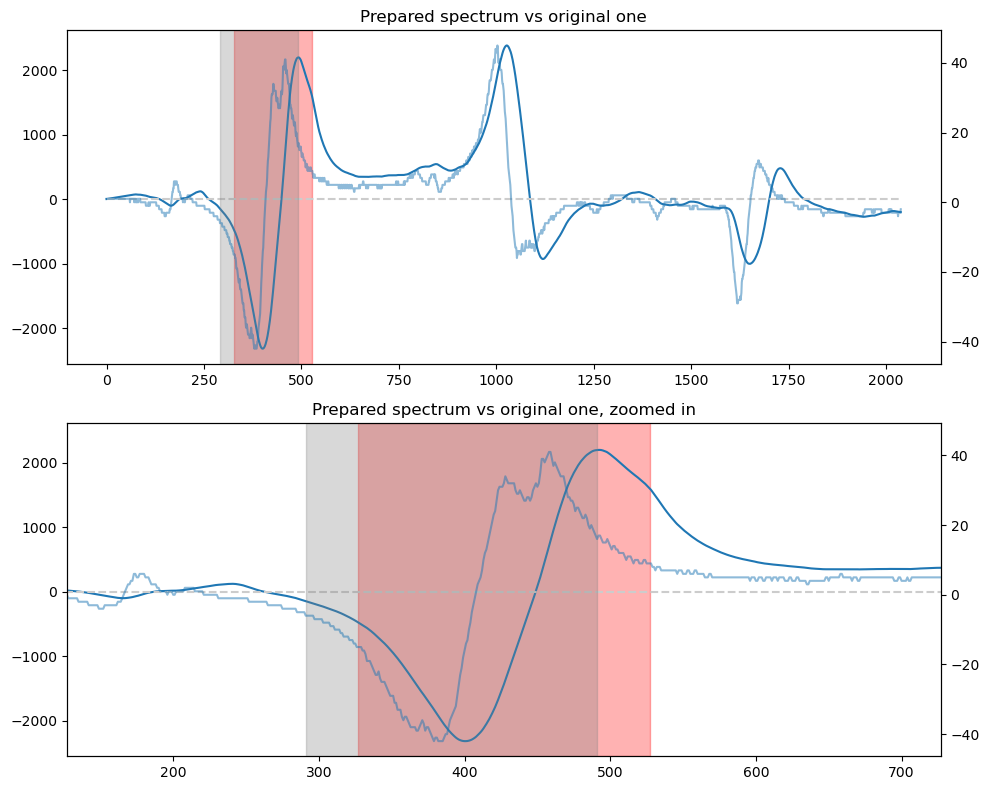

In [121]:

shift_prepared = np.argmax(correlate(prepared_spectrum, spectra_cropped[0]))-len(prepared_spectrum)
print('shift', shift_prepared)

target_idxs_prepared = [idx + shift_prepared for idx in target_idxs]

#--- prepared spectrum plot ---

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

ax0 = axs[0] # Primary y-axis
ax1 = ax0.twinx() # Secondary y-axis

ax0.plot(prepared_spectrum)
ax1.plot(spectra_cropped[0], alpha=0.5)

ax0.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax1.axvspan(target_idxs[0], target_idxs[1], color='grey', alpha=0.3)
ax0.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
ax0.set_title('Prepared spectrum vs original one')

ax2 = axs[1] # Primary y-axis
ax3 = ax2.twinx() # Secondary y-axis

ax2.plot(prepared_spectrum)
ax3.plot(spectra_cropped[0], alpha=0.5)

window_width_cropped_prepared = target_idxs_prepared[1] - target_idxs_prepared[0]
ax2.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
ax3.axvspan(target_idxs[0], target_idxs[1], color='grey', alpha=0.3)
ax2.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
ax2.set_xlim(target_idxs_prepared[0] - window_width_cropped_prepared, target_idxs_prepared[1] + window_width_cropped_prepared)
ax2.set_title('Prepared spectrum vs original one, zoomed in')

plt.tight_layout()
plt.plot()

Now the algorithm finds the peaks of the prepared signal.

extrema are 73 165
selected region is from  327 to 527
extremum is at 73
first peak is in  400  with value  -2320
peaks [(400, -2320), (241, 121), (166, -102), (75, 73)]
y_scale -2320


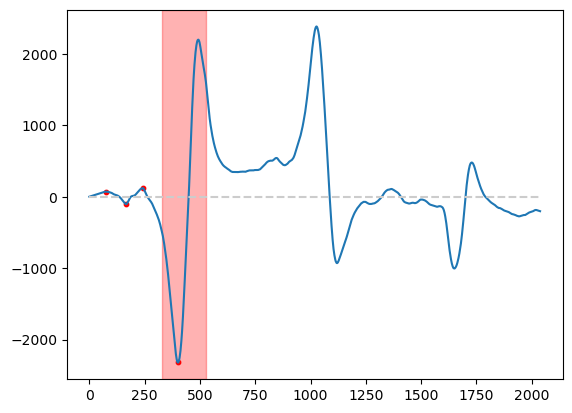

In [122]:
peaks = get_all_peaks(prepared_spectrum, target_idxs_prepared)
print('peaks', peaks)
plt.plot(prepared_spectrum)
plt.axvspan(target_idxs_prepared[0], target_idxs_prepared[1], color='red', alpha=0.3)
plt.hlines(0, 0, len(prepared_spectrum), color = '0.8', ls = '--')
for peak_position,peak_value in peaks:
    plt.scatter(peak_position, peak_value, color='red',s=10)
y_scale = peaks[0][1]
print('y_scale', y_scale)

[(231, 1038), (242, 1038), (231, 1039), (233, 1040), (230, 1039)]


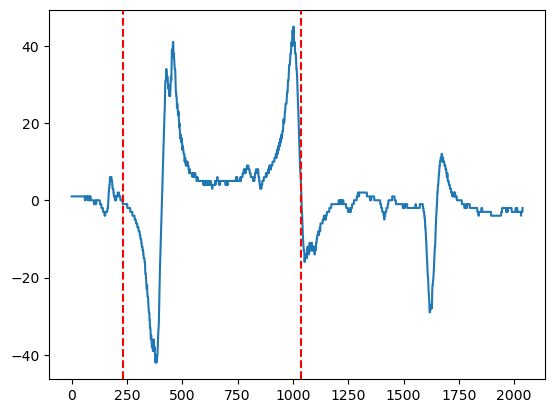

In [124]:
lock_regions = [get_lock_region(spectrum, target_idxs) for spectrum in spectra_cropped]
print(lock_regions)
plt.plot(spectra_cropped[0])
plt.axvline(x=lock_regions[0][0], color='r', linestyle='--')
plt.axvline(x=lock_regions[0][1], color='r', linestyle='--')

tolerance factor 0.95
peaks filtered [(388, -793.25), (189, 88.35), (162, -62.699999999999996)]
extrema are 0 21
selected region is from  406 to 428
target peak idx 406
final wait time 1
for tolerance 0.95 description is [(145, -62), (24, 88), (179, -793)]
lock_position 389
lock_position 383
tolerance factor 0.9
peaks filtered [(388, -751.5), (189, 83.7)]
extrema are 0 21
selected region is from  406 to 428
target peak idx 406
final wait time 1
for tolerance 0.9 description is [(170, 83), (179, -751)]
lock_position 382
lock_position 375
lock_position 380
lock_position 378
lock_position 378


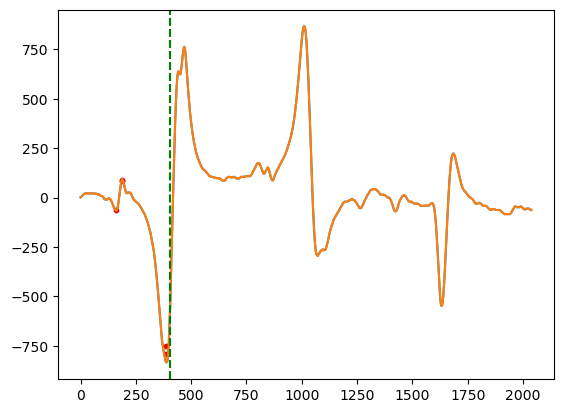

In [ ]:
for tolerance_factor in [0.95,0.9,0.85,0.8,0.75,0.7]:
        #logger.debug(f"Try out tolerance {tolerance_factor}")
        peaks_filtered = [
            (peak_position, peak_height * tolerance_factor)
            for peak_position, peak_height in peaks
        ]
        # it is important to do the filtering that happens here after the previous
        # line as the previous line shrinks the values
        peaks_filtered = [
            (peak_position, peak_height)
            for peak_position, peak_height in peaks_filtered
            if abs(peak_height) > abs(y_scale * (1 - tolerance_factor))
        ]
        print('tolerance factor', tolerance_factor)
        print('peaks filtered', peaks_filtered)
        # now find out how muget_diff_at_time_scalech we have to wait in the end (because we detect the peak
        # too early because our threshold is too low)
        target_peak_described_height = peaks_filtered[0][1]
        target_peak_idx = get_target_peak(prepared_spectrum, target_idxs_prepared)
        print('target peak idx', target_peak_idx)
        plt.plot(prepared_spectrum)
        plt.axvline(x=target_peak_idx, color='g', linestyle='--')
        #plt.axvline(x=1168, color='r', linestyle='--')
        #plt.axvline(x=1468, color='r', linestyle='--')
        for peak_position, peak_height in peaks_filtered:
            plt.scatter(peak_position, peak_height, color='red', s=10)
        current_idx = target_peak_idx
        while True:
            current_idx -= 1
            if np.abs(prepared_spectrum[current_idx]) < np.abs(
                target_peak_described_height
            ):
                break
        final_wait_time = target_peak_idx - current_idx
        #logger.debug(f"final wait time is {final_wait_time} samples")
        print('final wait time', final_wait_time)
        description = []

        last_peak_position = 0
        for peak_position, peak_height in list(reversed(peaks_filtered)):
            # TODO: this .9 factor is very arbitrary.
            description.append(
                (int(0.9 * (peak_position - last_peak_position)), int(peak_height))
            )
            last_peak_position = peak_position
        print('for tolerance', tolerance_factor, 'description is', description)
        # test whether description works fine for every recorded spectrum
        does_work = True
        for spectrum, lock_region in zip(spectra, lock_regions):
            try:
                lock_position = get_lock_position_from_autolock_instructions(
                    spectrum, description, time_scale, spectra_cropped[0], final_wait_time
                )
                print('lock_position', lock_position)
                if not lock_region[0] <= lock_position <= lock_region[1]:
                    print('LockPositionNotFound')

            except:
                does_work = False

        if does_work:
            break

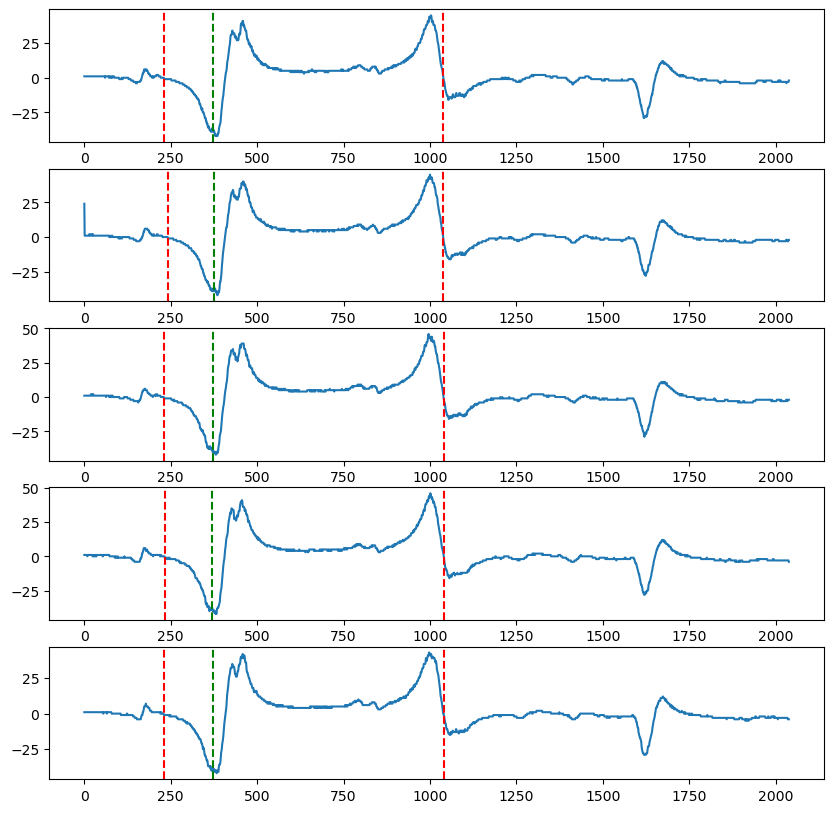

In [12]:
fig,ax = plt.subplots(ncols=1, nrows=N_SPECTRA, figsize=(10, 10))
for i in range(N_SPECTRA):
    ax[i].plot(spectra_cropped[i])
    ax[i].axvline(x=lock_regions[i][0], color='r', linestyle='--')
    ax[i].axvline(x=lock_regions[i][1], color='r', linestyle='--')
    lock_position = get_lock_position_from_autolock_instructions(
                    spectra_cropped[i], description, time_scale, spectra_cropped[0], final_wait_time
                )
    ax[i].axvline(x=lock_position, color='g', linestyle='--')

In [13]:
calculate_autolock_instructions(spectra,(1200,1500))

linien_server.autolock.robust  DEBUG    x scale is 114
linien_server.autolock.robust  DEBUG    Try out tolerance 0.95
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.9
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.85
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.8
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.75
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.7
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.65
linien_server.autolock.robust  DEBUG    final wait time is 59 samples
linien_server.autolock.

extrema are 0 198
selected region is from  1191 to 1491
first peak is 1191 -732
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.95 description is [(90, 76), (60, -71), (213, -2539), (563, 2754), (112, -1069)]
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.9 description is [(363, -2405), (563, 2609), (112, -1013)]
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.85 description is [(363, -2272), (563, 2464), (112, -957)]
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.8 description is [(363, -2138), (563, 2319), (112, -900)]
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.75 description is [(363, -2004), (563, 2174), (112, -844)]
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.7 description is [(363, -1871), (563, 2029), (112, -788)]
extrema are 0 198
selected region is from  1191 to 1491
for tolerance 0.65 description is [(363, -1737), (563, 188

UnableToFindDescription: 